In [1]:
%cd /Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas

/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas


/Users/oscarmauriciomoraarroyo/proyecto_lyapunov_chagas/.venv/lib/python3.9/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


# Cálculo del exponente de Lyapunov para el modelo SEIR calibrado (Valledupar)

En este cuaderno se calcula el exponente de Lyapunov máximo para el modelo SEIR
calibrado con los datos de enfermedad de Chagas en Valledupar (Cesar). El objetivo
es caracterizar la estabilidad dinámica del sistema y la sensibilidad a las
condiciones iniciales, usando los parámetros obtenidos en el proceso de
calibración previo.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import json
from scipy.integrate import solve_ivp

In [3]:
PARAMS_OPT_PATH = Path("models/seir_params_opt_valledupar.json")

with PARAMS_OPT_PATH.open() as f:
    params_opt = json.load(f)

params_opt

{'municipio': 'Valledupar',
 'beta': 4.9999999999999996e-06,
 'sigma': 1e-06,
 'gamma': 2.0,
 'N': 100000,
 'rmse': 8.275353858384635,
 'c': 0.25,
 'N0': 9215.031671393344}

## 1. Definición del sistema SEIR con parámetros calibrados

Se reutiliza el sistema SEIR con incidencia no lineal y migración usado en el
proceso de calibración. En este cuaderno se trabaja con los parámetros ya
calibrados para Valledupar, lo que permite interpretar el exponente de Lyapunov
en el contexto epidemiológico de este municipio.

In [4]:
def prepare_params(params):
    """
    Arma un diccionario de parámetros completo y robusto a partir de params.
    Asigna valores por defecto si falta alguno.
    """
    p = params.copy()

    N0 = float(p.get("N0", 3500.0))
    beta  = float(p.get("beta", 0.2))
    alpha = float(p.get("alpha", 0.01))
    sigma = float(p.get("sigma", 1/60))
    gamma = float(p.get("gamma", 1/180))
    mu    = float(p.get("mu", 0.000039))
    c     = float(p.get("c", 0.05))
    d     = float(p.get("d", 1/365))
    m_out = float(p.get("m_out", 0.017))

    Lambda = p.get("Lambda", mu * N0)

    p_clean = {
        "N0": N0,
        "beta": beta,
        "alpha": alpha,
        "sigma": sigma,
        "gamma": gamma,
        "mu": mu,
        "c": c,
        "d": d,
        "m_out": m_out,
        "Lambda": Lambda,
    }
    return p_clean

p_clean = prepare_params(params_opt)
p_clean

{'N0': 9215.031671393344,
 'beta': 4.9999999999999996e-06,
 'alpha': 0.01,
 'sigma': 1e-06,
 'gamma': 2.0,
 'mu': 3.9e-05,
 'c': 0.25,
 'd': 0.0027397260273972603,
 'm_out': 0.017,
 'Lambda': 0.35938623518434043}

In [5]:
def seir_system(t, y, p):
    """
    Sistema SEIR con incidencia no lineal y migración.
    y = [S, E, I, R, V]
    """
    S, E, I, R, V = y

    beta  = p["beta"]
    alpha = p["alpha"]
    sigma = p["sigma"]
    gamma = p["gamma"]
    mu    = p["mu"]
    c     = p["c"]
    d     = p["d"]
    m_out = p["m_out"]
    Lambda = p["Lambda"]

    N = S + E + I + R
    if N <= 0:
        return [0.0, 0.0, 0.0, 0.0, 0.0]

    infection = beta * S * V / (1.0 + alpha * I)

    dSdt = Lambda - infection - (mu + m_out) * S
    dEdt = infection - (sigma + mu + m_out) * E
    dIdt = sigma * E - (gamma + mu + m_out) * I
    dRdt = gamma * I - (mu + m_out) * R
    dVdt = c * I - d * V

    return [dSdt, dEdt, dIdt, dRdt, dVdt]

## 2. Método de Benettin para el exponente de Lyapunov máximo

Para estimar el exponente de Lyapunov máximo se utiliza una versión del método
propuesto por Benettin et al.:

1. Se fijan parámetros del modelo y condiciones iniciales \(y_0\).
2. Se construye una segunda condición inicial ligeramente perturbada
   \(y_0' = y_0 + \delta y_0\), con \(\|\delta y_0\| = \delta_0\).
3. Se integran ambas trayectorias durante un intervalo de tiempo \(\Delta t\).
4. Se calcula la distancia \(\|\delta y\|\) entre las dos soluciones.
5. Se acumula \(\ln(\|\delta y\| / \delta_0)\).
6. Se renormaliza la perturbación a norma \(\delta_0\) alrededor de la
   trayectoria de referencia y se repite el proceso varias veces.

El exponente de Lyapunov máximo se aproxima como:

\[
\lambda \approx \frac{1}{T} \sum_{k=1}^{n} \ln \left( \frac{\|\delta y_k\|}{\delta_0} \right),
\]

donde \(T = n \Delta t\) es el horizonte total de integración.

In [6]:
def integrate_trajectory(y0, p, t0, t1, dt=1.0):
    """
    Integra el sistema SEIR desde t0 hasta t1 con paso aproximado dt.
    Devuelve (t, Y) donde Y es un arreglo 2D con columnas = estados en el tiempo.
    """
    t_eval = np.arange(t0, t1 + dt, dt)

    sol = solve_ivp(
        lambda t, y: seir_system(t, y, p),
        (t0, t1),
        y0,
        t_eval=t_eval,
        vectorized=False,
    )
    return sol.t, sol.y

In [7]:
def lyapunov_maximum(params, T_total=365, dt_block=7, delta0=1e-4):
    """
    Calcula el exponente de Lyapunov máximo usando el método de Benettin.
    
    params   : diccionario de parámetros (ya limpiado con prepare_params)
    T_total  : tiempo total de integración (días)
    dt_block : tamaño de cada bloque de integración (días)
    delta0   : norma inicial de la perturbación
    """
    p = prepare_params(params)

    N0 = p["N0"]
    # Condiciones iniciales base (coherentes con simulate_seir)
    I0 = 1.0
    E0 = 0.0
    R0 = 0.0
    V0 = 1.0
    S0 = N0 - I0 - E0 - R0

    y1 = np.array([S0, E0, I0, R0, V0], dtype=float)

    # Perturbación inicial en un componente (por ejemplo, I)
    v0 = np.array([0.0, 0.0, 1.0, 0.0, 0.0], dtype=float)
    v0 = v0 / np.linalg.norm(v0) * delta0
    y2 = y1 + v0

    n_blocks = int(T_total / dt_block)
    sum_logs = 0.0

    distances = []
    times = []

    t_current = 0.0

    for k in range(n_blocks):
        t_next = t_current + dt_block

        # Integrar trayectoria de referencia
        t1, Y1 = integrate_trajectory(y1, p, t_current, t_next, dt=1.0)
        # Integrar trayectoria perturbada
        t2, Y2 = integrate_trajectory(y2, p, t_current, t_next, dt=1.0)

        # Tomar el estado final de cada trayectoria
        y1_final = Y1[:, -1]
        y2_final = Y2[:, -1]

        # Distancia entre trayectorias
        diff = y2_final - y1_final
        d = np.linalg.norm(diff)

        if d == 0:
            # Si por alguna razón se colapsan, no aporta al cálculo
            d = 1e-16

        sum_logs += np.log(d / delta0)

        distances.append(d)
        times.append(t_next)

        # Renormalizar perturbación alrededor de la trayectoria de referencia
        v = diff / d * delta0
        y1 = y1_final
        y2 = y1_final + v

        t_current = t_next

    T = n_blocks * dt_block
    lambda_max = sum_logs / T

    results = pd.DataFrame({"t": times, "distancia": distances})

    return lambda_max, results

In [8]:
lambda_max, dist_df = lyapunov_maximum(params_opt, T_total=365, dt_block=7, delta0=1e-5)
lambda_max

np.float64(-0.00845768113740105)

## 3. Resultados del exponente de Lyapunov

A continuación se presenta la evolución de la distancia entre dos trayectorias
inicialmente cercanas y el valor estimado del exponente de Lyapunov máximo.

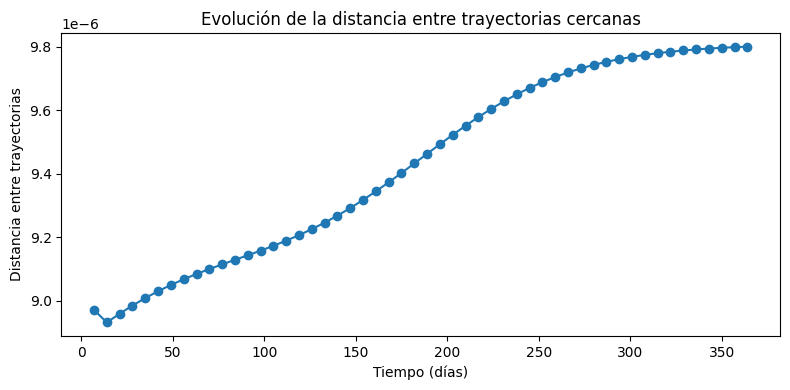

np.float64(-0.00845768113740105)

In [9]:
plt.figure(figsize=(8, 4))
plt.plot(dist_df["t"], dist_df["distancia"], marker="o")
plt.xlabel("Tiempo (días)")
plt.ylabel("Distancia entre trayectorias")
plt.title("Evolución de la distancia entre trayectorias cercanas")
plt.tight_layout()
plt.show()

lambda_max

### Interpretación del exponente de Lyapunov

El valor estimado del exponente de Lyapunov máximo \(\lambda_{\max}\) resume la
sensibilidad del sistema SEIR calibrado frente a pequeñas perturbaciones en las
condiciones iniciales:

- Si \(\lambda_{\max} > 0\), el sistema presenta sensibilidad exponencial a las
  condiciones iniciales, lo que indica un comportamiento inestable o caótico en
  el horizonte de tiempo considerado.
- Si \(\lambda_{\max} \approx 0\), el sistema se encuentra en un régimen cercano
  al equilibrio o en el borde de la estabilidad.
- Si \(\lambda_{\max} < 0\), las trayectorias cercanas tienden a converger, lo
  que indica estabilidad local frente a perturbaciones pequeñas.

En el contexto de este proyecto, el valor obtenido para \(\lambda_{\max}\),
calculado con los parámetros calibrados para Valledupar, permite caracterizar la
estabilidad de la dinámica de transmisión de la enfermedad de Chagas bajo las
condiciones asumidas por el modelo SEIR. Este resultado se puede integrar en la
discusión del comportamiento epidemiológico y en la interpretación del riesgo de
cambios abruptos frente a variaciones pequeñas en el sistema.